In [9]:
%load_ext autoreload
%autoreload 2

The following cell plots the average time taken to validate a 
candidate password. You can see how better candidates
take more time to validate:

11111111 - 594.84
12111111 - 583.0
12311111 - 687.36
12341111 - 641.76
12345111 - 663.0
12345611 - 766.36
12345671 - 773.24
12345678 - 776.84


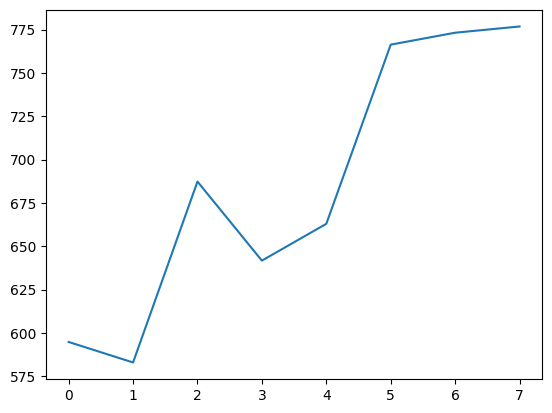

In [20]:
import time

from matplotlib import pyplot as plt

from auth import validate


candidates = [
    "11111111",
    "12111111",
    "12311111",
    "12341111",
    "12345111",
    "12345611",
    "12345671",
    "12345678",
]

nanoseconds = [0 for _ in range(8)]

for i, candidate in enumerate(candidates):
    accumulator = 0
    iterations = 25
    for j in range(iterations):
        start = time.time_ns()
        validate(candidate)
        end = time.time_ns()
        accumulator += end - start
    nanoseconds[i] = accumulator / iterations
    print(f"{candidate} - {nanoseconds[i]}")

plt.plot(nanoseconds)

The following cell runs a Genetic Algorithm to 
execute a timing attack on the weak password 
validation function:

Initial Population

Member 12768226 Fitness 3468.0
Member 45272323 Fitness 577.0
Member 36282187 Fitness 428.0
Member 38366232 Fitness 405.0
Member 38214326 Fitness 408.0
Member 34783646 Fitness 431.0
Member 62561463 Fitness 406.0
Member 22862536 Fitness 505.0
Member 36685785 Fitness 412.0
Member 74548746 Fitness 409.0
Member 86278651 Fitness 451.0
Member 46154556 Fitness 424.0
Member 77826454 Fitness 403.0
Member 61416445 Fitness 408.0
Member 73281347 Fitness 7974.0
Member 48536873 Fitness 1292.0
Member 16337357 Fitness 759.0
Member 56663723 Fitness 431.0
Member 28436716 Fitness 410.0
Member 62113735 Fitness 424.0
Member 16775437 Fitness 480.0
Member 46281544 Fitness 422.0
Member 64366128 Fitness 421.0
Member 86344167 Fitness 408.0
Member 71561246 Fitness 406.0
Member 57246453 Fitness 414.0
Member 13524783 Fitness 479.0
Member 11883634 Fitness 474.0
Member 72868768 Fitness 413.0
Member 84372441 Fitness 406.0
Member 78437762 Fitness 420.0
Member 67343167 Fitness 404.0
Member 53128664 F

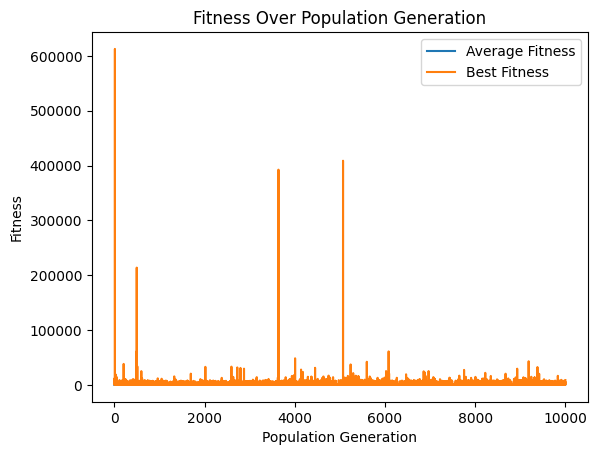

In [21]:
from ga import main

main()